In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import numpy as np
import numba as nb
import awkward as ak
import math

In [2]:
@nb.njit()
def trilepton_selection(ee_starts, ee_stops, ee_arg0s, ee_arg1s,
                        mm_starts, mm_stops, mm_arg0s, mm_arg1s,
                        e_starts, e_stops, e_px, e_py, e_pz, e_E,
                        mu_starts, mu_stops, mu_px, mu_py, mu_pz, mu_E):
    # as input we receive the indices of the best os/sf pairs
    # here we need to figure out if there's a contention between ee and mm
    # arbitrate and then select the appropriate third, highest pT lepton
    # we will return the mask that selects the lepton
    pole = 91.18
    e_out = np.zeros(e_px.size, nb.boolean)
    mu_out = np.zeros(mu_px.size, nb.boolean)
    ee_out = np.zeros(ee_arg0s.size, nb.boolean)
    mm_out = np.zeros(mm_arg0s.size, nb.boolean)

    for i_evt in range(ee_starts.size):
        best_ll = []
        best_ll_index = []
        n_lls = 0
        ll_type = 0
        for i_ee in range(ee_starts[i_evt], ee_stops[i_evt]):
            best_ll.append((e_starts[i_evt] + ee_arg0s[i_ee], e_starts[i_evt] +  ee_arg1s[i_ee]))
            best_ll_index.append(i_ee)
            n_lls += 1
            ll_type += 0
        for i_mm in range(mm_starts[i_evt], mm_stops[i_evt]):
            best_ll.append((mu_starts[i_evt] + mm_arg0s[i_mm], mu_starts[i_evt] + mm_arg1s[i_mm]))
            best_ll_index.append(i_mm)
            n_lls += 1
            ll_type += 1        

        ee_mass = 0.0
        mm_mass = 0.0
        if n_lls == 0:
            continue
        elif n_lls == 1:
            pass
        else:
            ee0, ee1 = best_ll[0]
            ee_mass = np.sqrt((e_E[ee0] + e_E[ee1])**2 - 
                              ((e_px[ee0] + e_px[ee1])**2 +
                               (e_py[ee0] + e_py[ee1])**2 +
                               (e_pz[ee0] + e_pz[ee1])**2))
            mm0, mm1 = best_ll[1]
            mm_mass = np.sqrt((mu_E[mm0] + mu_E[mm1])**2 - 
                              ((mu_px[mm0] + mu_px[mm1])**2 + 
                               (mu_py[mm0] + mu_py[mm1])**2 + 
                               (mu_pz[mm0] + mu_pz[mm1])**2))
            ll_type = int(np.abs(ee_mass - pole) >= np.abs(mm_mass - pole))

        ll0, ll1 = best_ll[0] if n_lls == 1 else best_ll[ll_type]

        if ll_type == 0:
            ee_out[best_ll_index[0]] = True
        else:
            idx = n_lls - 1
            mm_out[best_ll_index[idx]] = True

        best_third_type = -1 
        best_third_lepton = -1 
        best_third_lepton_pt = 0.
        for i_e in range(e_starts[i_evt], e_stops[i_evt]):
            if ll_type == 0:
                if i_e == ll0 or i_e == ll1:
                    continue
            if best_third_type is None:
                best_third_type = 0
                best_third_lepton = i_e
                best_third_lepton_pt = np.sqrt(e_px[i_e]**2 + e_py[i_e]**2)
            else:
                i_e_pt = np.sqrt(e_px[i_e]**2 + e_py[i_e]**2)
                if i_e_pt > best_third_lepton_pt:
                    best_third_type = 0
                    best_third_lepton = i_e
                    best_third_lepton_pt = i_e_pt

        for i_mu in range(mu_starts[i_evt], mu_stops[i_evt]):
            if ll_type == 1:
                if i_mu == ll0 or i_mu == ll1:
                    continue
            if best_third_type is None:
                best_third_type = 1
                best_third_lepton = i_mu
                best_third_lepton_pt = np.sqrt(mu_px[i_mu]**2 + mu_py[i_mu]**2)
            else:
                i_mu_pt = np.sqrt(mu_px[i_mu]**2 + mu_py[i_mu]**2)
                if i_mu_pt > best_third_lepton_pt:
                    best_third_type = 1
                    best_third_lepton = i_mu
                    best_third_lepton_pt = i_mu_pt
        
        if best_third_type > -1:
            if best_third_type == 0:
                e_out[best_third_lepton] = True
            if best_third_type == 1:
                mu_out[best_third_lepton] = True
        
        
    return e_out, mu_out, ee_out, mm_out

In [3]:
# This program plots the transverse mass of MET and a third lepton, where the third lepton is associated with a lepton pair
# that has the same flavor, opposite charge, and closest mass to 91.2.

import math

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "MET and Third Lepton")
        muon_axis = hist.Bin("massT", "Transverse Mass", 50, 15, 250)
        
        self._accumulator = processor.dict_accumulator({
            'massT': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]

        muons = JaggedCandidateArray.candidatesfromcounts(
                    df['nMuon'],
                    pt=df['Muon_pt'].content,
                    eta=df['Muon_eta'].content,
                    phi=df['Muon_phi'].content,
                    mass=df['Muon_mass'].content,
                    charge=df['Muon_charge'].content
                    )
        electrons = JaggedCandidateArray.candidatesfromcounts(
                    df['nElectron'],
                    pt=df['Electron_pt'].content,
                    eta=df['Electron_eta'].content,
                    phi=df['Electron_phi'].content,
                    mass=df['Electron_mass'].content,
                    charge=df['Electron_charge'].content
                    )
        
        # a few reasonable muon and electron selection cuts
        muons = muons[(muons.pt > 10) & (np.abs(muons.eta) < 2.4)]
        electrons = electrons[(electrons.pt > 10) & (np.abs(electrons.eta) < 2.5)]
        trileptons = (muons.counts + electrons.counts) >= 3
        muons = muons[trileptons].compact()
        electrons = electrons[trileptons].compact()
                
        diele = electrons.distincts()
        dimu = muons.distincts()
        
        # same for dileptons
        diele = diele[(diele.i0.charge * diele.i1.charge < 0) & (diele.mass > 50) & (diele.mass < 160)]
        dimu = dimu[(dimu.i0.charge * dimu.i1.charge < 0) & (dimu.mass > 50) & (dimu.mass < 160)]
        
        #get the dileptons closest to the z-pole
        best_diele = np.abs(diele.mass - 91.18).argmin()
        best_dimu = np.abs(dimu.mass - 91.18).argmin()
        
        diele_args = electrons.argdistincts()[best_diele].compact()
        dimu_args = muons.argdistincts()[best_dimu].compact()
        
        # select the third lepton with highest pT that's not in the z-candidate
        # it returns a mask that selects the appropriate dilepton and third lepton
        # the mask is already exclusive across lepton types
        e_mask_contents, mu_mask_contents, ee_mask_contents, mm_mask_contents = \
            trilepton_selection(diele_args.starts, diele_args.stops, diele_args.i0.content, diele_args.i1.content,
                                dimu_args.starts, dimu_args.stops, dimu_args.i0.content, dimu_args.i1.content,
                                electrons.starts, electrons.stops, 
                                electrons.p4.x.content, electrons.p4.y.content, 
                                electrons.p4.z.content, electrons.p4.energy.content,
                                muons.starts, muons.stops, 
                                muons.p4.x.content, muons.p4.y.content, 
                                muons.p4.z.content, muons.p4.energy.content)
        
        e_mask = ak.JaggedArray.fromoffsets(electrons.offsets,e_mask_contents)
        mu_mask = ak.JaggedArray.fromoffsets(muons.offsets,mu_mask_contents)
        
        ee_mask = ak.JaggedArray.fromoffsets(diele_args.offsets,ee_mask_contents)
        mm_mask = ak.JaggedArray.fromoffsets(dimu_args.offsets,mm_mask_contents)
        
        third_es = electrons[e_mask]
        third_ms = muons[mu_mask]
        
        #print(ee_mask)
        #print(mm_mask)
        #print()
        #print(e_mask)
        #print(mu_mask)
        
        MET_pt = df['MET_pt'][trileptons]
        MET_phi = df['MET_phi'][trileptons]    

        MET_tab = ak.JaggedArray.fromcounts(np.ones_like(MET_pt, dtype=np.int), ak.Table({'phi': MET_phi, 'pt': MET_pt}))
        
        met_plus_e = MET_tab.cross(third_es)
        met_plus_mu = MET_tab.cross(third_ms)

        dphi_met_e = (met_plus_e.i0.phi - met_plus_e.i1.p4.phi + math.pi) % (2*math.pi) - math.pi
        dphi_met_mu = (met_plus_mu.i0.phi - met_plus_mu.i1.p4.phi + math.pi) % (2*math.pi) - math.pi
        
        mt_e = np.sqrt(2.0*met_plus_e.i0.pt*met_plus_e.i1.p4.pt*(1.0-np.cos(dphi_met_e)))
        mt_mu = np.sqrt(2.0*met_plus_mu.i0.pt*met_plus_mu.i1.p4.pt*(1.0-np.cos(dphi_met_mu)))

        output['massT'].fill(dataset=dataset, massT=mt_e.flatten())
        output['massT'].fill(dataset=dataset, massT=mt_mu.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
fileset = {'SingleMu': ["data/Run2012B_SingleMu.root"]}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 250000)

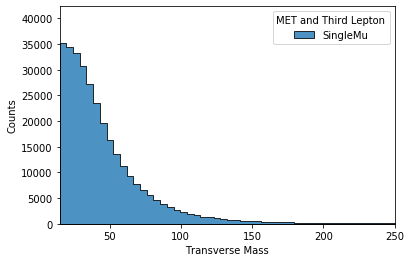

In [5]:
hist.plot1d(output['massT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)